In [20]:
from math import trunc
import unittest
import numpy as np
import scipy.sparse as sp
from qiskit.algorithms.evolvers.classical_real_evolver import ClassicalRealEvolver
from test.python.algorithms import QiskitAlgorithmsTestCase
from ddt import data, ddt, unpack
from numpy.testing import assert_raises

from qiskit.quantum_info import Statevector
from qiskit.algorithms.evolvers.evolution_problem import EvolutionProblem
from qiskit.circuit import Parameter
from qiskit.opflow import Y, Z, I, One, X, Zero, VectorStateFn, StateFn, SummedOp, PauliSumOp
from scipy.sparse.linalg import bicg,norm
import matplotlib.pyplot as plt
import time

In [21]:
def create_hamiltonian(num_sites):
    J = 0.1
    g = -1.0

    zz = ["I" * i + "ZZ" + "I" * (num_sites - i - 2) for i in range(num_sites - 1)]
    x = ["I" * i + "X" + "I" * (num_sites - i - 1) for i in range(num_sites)]
    return PauliSumOp.from_list(list(zip(zz, len(zz) * [J])) + list(zip(x, len(x) * [g])))


In [24]:
print(create_hamiltonian(5))

0.1 * ZZIII
+ 0.1 * IZZII
+ 0.1 * IIZZI
+ 0.1 * IIIZZ
- 1.0 * XIIII
- 1.0 * IXIII
- 1.0 * IIXII
- 1.0 * IIIXI
- 1.0 * IIIIX


In [3]:

def time_step(num_sites):
    initial_state = np.zeros(2 ** num_sites, dtype=np.complex128)
    initial_state[0] = 1.0
    initial_state = VectorStateFn(initial_state)

    evolution_problem = EvolutionProblem(create_hamiltonian(num_sites),1.0,initial_state,truncation_threshold=1e-5)
    classic_evolver = ClassicalRealEvolver(timesteps=10)
    a = time.time()
    state, lhs_operator, rhs_operator, timesteps = classic_evolver._start(evolution_problem=evolution_problem)
    b = time.time()
    classic_evolver._step(state, lhs_operator, rhs_operator)
    c = time.time()
    return b-a, c-b


In [11]:
def state_steps(num_sites, timesteps):
    hamiltonian = create_hamiltonian(num_sites)
    initial_state = np.zeros(2 ** num_sites, dtype=np.complex128)
    initial_state[0] = 1.0
    initial_state = VectorStateFn(initial_state)
    evolution_problem = EvolutionProblem(hamiltonian,1.0,initial_state)
    classic_evolver = ClassicalRealEvolver(timesteps=timesteps)
    return classic_evolver.evolve(evolution_problem).evolved_state.to_matrix()

def recomended_steps(num_sites,  threshold , t =1.0):
    norm_hamiltonian = sp.linalg.norm(create_hamiltonian(num_sites).to_spmatrix(), ord = 1)
    return int( np.power(norm_hamiltonian * t, 3 / 2) * np.power(12 * threshold, -1 / 2) ) + 1

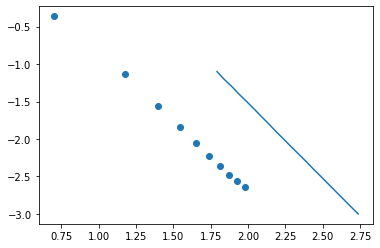

In [19]:
steps = np.arange(5,100,10)
n_qubits = 14
reference_state = state_steps(n_qubits,10000)
states = [state_steps(n_qubits,i) for i in steps]
errors = [np.linalg.norm(state-reference_state) for state in states]

errrs = np.arange(-3,-1,step = 1e-1)
stpss = [recomended_steps(n_qubits, 10**errr ) for errr in errrs]

plt.scatter(np.log10(steps),np.log10(errors))
plt.plot(np.log10(stpss),errrs)

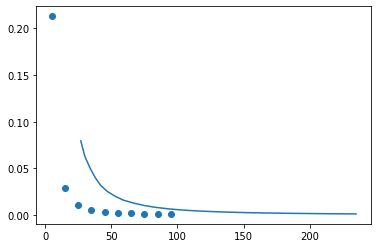

In [18]:
plt.scatter(steps,errors)
plt.plot(stpss,10**errrs)

In [38]:
num_sites = 8

hamiltonian = create_hamiltonian(num_sites)
sphamiltonian = hamiltonian.to_spmatrix()

initial_state = np.zeros(2 ** num_sites, dtype=np.complex128)
initial_state[0] = 1.0
initial_state = VectorStateFn(initial_state)

evolution_problem = EvolutionProblem(hamiltonian,1.0,initial_state)
classic_evolver = ClassicalRealEvolver(timesteps=None, threshold = 1e-5)
print("The inf norm of the hamiltonian is:", sp.linalg.norm(sphamiltonian, ord=np.inf))
recomended_steps = classic_evolver.minimal_number_steps(1,1.0,1e-5)
print("The recomended number of steps is:",recomended_steps)
result = classic_evolver.evolve(evolution_problem)

time_evolution_operator = sp.linalg.expm(-1.0j * sphamiltonian)
exact_evolved = time_evolution_operator.dot(initial_state.primitive)

print(np.linalg.norm(exact_evolved))
print(np.linalg.norm(result.evolved_state.to_matrix()))
print(np.linalg.norm(exact_evolved - result.evolved_state.to_matrix()))




The inf norm of the hamiltonian is: 8.7
The recomended number of steps is: 91


/home/msd/anaconda3/envs/terra/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:322: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)
/home/msd/anaconda3/envs/terra/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:215: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  warn('spsolve is more efficient when sparse b '


1.0
1.001567212429437
0.002783557463746078


In [4]:
list_timesteps = np.arange(10,23)
aa = [time_step(i) for i in list_timesteps]
bb = list(zip(*aa))
init_time = np.array(list(bb[0]))
step_time = np.array(list(bb[1]))

ValueError: too many values to unpack (expected 3)

In [5]:
from scipy.stats import linregress

ext_qubits = 27


slope_A, intercept_A, r_value, p_value, std_err = linregress(list_timesteps, np.log10(init_time))
print(slope_A, intercept_A, r_value, p_value, std_err)


time_A = 10**(intercept_A + ext_qubits * slope_A)
print(f"For {ext_qubits} qubits it would take {time.strftime('%H:%M:%S', time.gmtime(time_A)) } to initialize.")

slope_B, intercept_B, r_value, p_value, std_err = linregress(list_timesteps, np.log10(step_time))
print(slope_B, intercept_B, r_value, p_value, std_err)

time_B = 10**(intercept_B + ext_qubits * slope_B)
print(f"For {ext_qubits} qubits it would take {time.strftime('%H:%M:%S', time.gmtime(time_B))} to make a step.")


plt.scatter(list_timesteps,np.log10(init_time))
plt.plot(list_timesteps,intercept_A + list_timesteps*slope_A)
plt.scatter(list_timesteps,np.log10(step_time))
plt.plot(list_timesteps,intercept_B + list_timesteps*slope_B)
plt.legend(['Initialization','Init Regression','Step','Step Regresion'])

NameError: name 'init_time' is not defined

In [6]:
print(time_step(22))

(113.99851536750793, 18.394944429397583)
